In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2
#import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import os
from PIL import Image
import torchvision.transforms as transforms
import time
from tqdm import tqdm

# Para evitar recargar los datos en cada arranque del entorno de ejecución
# Montamos la unidad de drive y trabajamos con los datos allí almacenados
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
datasetdir = '/content/drive/MyDrive/cbis-ddsm'
modelsdir = '/content/drive/MyDrive/cbis-ddsm/models'
df = pd.read_csv(f'{datasetdir}/csv/dicom_info.csv')
df['image_path'] = df.image_path.apply(lambda x: x.replace('CBIS-DDSM', datasetdir))

In [ ]:
X_train = torch.load(datasetdir + "/X_train_balanced.pt")
y_train = torch.load(datasetdir + "/y_train_balanced.pt")
X_test = torch.load(datasetdir + "/X_test.pt")
y_test = torch.load(datasetdir + "/y_test.pt")

In [ ]:
print('X train shape : {}' .format(X_train.shape))
print('y train shape : {}' .format(y_train.shape))
print('X test shape : {}' .format(X_test.shape))
print('y test shape : {}' .format(y_test.shape))

X train shape : torch.Size([3366, 1, 224, 224])
y train shape : torch.Size([3366])
X test shape : torch.Size([422, 1, 224, 224])
y test shape : torch.Size([422])


In [ ]:
models_list = []
train_losses_list = []
train_accuracies_list = []
val_losses_list = []
val_accuracies_list = []

In [ ]:
# @title Funciones generales (callbacks, entrenar, métricas)
## Definición de clase para el callback "Early Stopping"
class EarlyStopping:
    def __init__(self, path, patience=3, verbose=False, delta=0.001):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.val_loss_min = float('inf')
        self.path = path  # Archivo donde guardaremos el modelo

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping no mejoró en {self.counter} épocas')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if val_loss < self.val_loss_min:
            if self.verbose:
                print(f'Validation loss mejorada a {val_loss:.6f}. Guardando modelo...')
            torch.save(model, self.path)
            self.val_loss_min = val_loss

def trainModel(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, early_stopping):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0
        correct_train = 0
        total_train = 0

        model.train()  # Modo de entrenamiento

        # Bucle de entrenamiento
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Precisión  entrenamiento
            predicted = torch.sigmoid(outputs)  # Aplicar sigmoide
            predicted = (predicted > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validación
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # Sin cálculos de gradientes durante la validación
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.float().view(-1, 1)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Precisión de validación
                predicted = torch.sigmoid(outputs)
                predicted = (predicted > 0.5).float()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_duration = end_time - start_time  # Duración de la época

        print(f"Train Loss: {avg_train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Time: {epoch_duration:.2f} seconds")

        # Aplicar Early Stopping y guardar modelo si corresponde
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early Stopping activado. Proceso detenido!")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

def metrics(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)

        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    binary_preds = (all_preds > 0.5).astype(int)

    conf_matrix = confusion_matrix(all_labels, binary_preds)

    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predicciones')
    plt.ylabel('Realidad')
    plt.title('Matriz de Confusión - Existencia de cáncer')
    plt.show()

    accuracy = accuracy_score(all_labels, binary_preds)
    report = classification_report(all_labels, binary_preds, target_names=['Negativo', 'Positivo'])

    print(f"Precisión global: {accuracy * 100:.2f}%")
    print("\nInforme y métricas de clasificación:")
    print(report)

    precision = precision_score(all_labels, binary_preds)
    recall = recall_score(all_labels, binary_preds)
    f1 = f1_score(all_labels, binary_preds)
    accuracy = accuracy_score(all_labels, binary_preds)

    print(f"Precisión: {precision:.2f}")
    print(f"Sensibilidad (Recall): {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    true_negatives = conf_matrix[0, 0]
    false_positives = conf_matrix[0, 1]
    true_positives = conf_matrix[1, 1]
    false_negatives = conf_matrix[1, 0]

    specificity = true_negatives / (true_negatives + false_positives)

    print(f"Especificidad: {specificity:.2f}")

    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

def graphLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))

    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Val Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Model Loss')
    axs[0].legend(loc='upper left')

    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Val Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Model Accuracy')
    axs[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
## RED NEURONAL CONVOLUCIONAL SIMPLE con 4 capas de convolución
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()

        # Capa de entrada con Batch Normalization
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Normalización
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)  # Dropout para reducir el overfitting
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
# Dataset y DataLoader estándares
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [ ]:
model = CNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = datasetdir + '/CNN.pth'
eaStop = EarlyStopping(fichModel, patience=30, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, train_accu, val_losses, val_accu = trainModel(model,train_loader,test_loader,criterion,optimizer,60,device,eaStop)

Epoch 1/60: 100%|██████████| 210/210 [00:06<00:00, 33.44it/s]


Train Loss: 0.689, Train Accuracy: 55.15%, Val Loss: 0.6954, Val Accuracy: 53.37%, Time: 6.56 seconds
Validation loss mejorada a 0.695414. Guardando modelo...


Epoch 2/60: 100%|██████████| 210/210 [00:05<00:00, 35.16it/s]


Train Loss: 0.651, Train Accuracy: 61.55%, Val Loss: 0.6934, Val Accuracy: 55.29%, Time: 6.26 seconds
Validation loss mejorada a 0.693437. Guardando modelo...


Epoch 3/60: 100%|██████████| 210/210 [00:05<00:00, 35.67it/s]


Train Loss: 0.598, Train Accuracy: 67.59%, Val Loss: 0.7093, Val Accuracy: 59.38%, Time: 6.16 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 4/60: 100%|██████████| 210/210 [00:05<00:00, 35.07it/s]


Train Loss: 0.520, Train Accuracy: 73.45%, Val Loss: 0.7843, Val Accuracy: 60.10%, Time: 6.27 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 5/60: 100%|██████████| 210/210 [00:05<00:00, 35.43it/s]


Train Loss: 0.418, Train Accuracy: 79.79%, Val Loss: 0.9150, Val Accuracy: 60.10%, Time: 6.21 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 6/60: 100%|██████████| 210/210 [00:05<00:00, 35.15it/s]


Train Loss: 0.313, Train Accuracy: 86.10%, Val Loss: 0.9988, Val Accuracy: 61.54%, Time: 6.27 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 7/60: 100%|██████████| 210/210 [00:05<00:00, 35.79it/s]


Train Loss: 0.229, Train Accuracy: 90.54%, Val Loss: 1.1351, Val Accuracy: 61.30%, Time: 6.15 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 8/60: 100%|██████████| 210/210 [00:05<00:00, 35.63it/s]


Train Loss: 0.150, Train Accuracy: 94.61%, Val Loss: 1.6084, Val Accuracy: 63.70%, Time: 6.19 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 9/60: 100%|██████████| 210/210 [00:05<00:00, 35.59it/s]


Train Loss: 0.105, Train Accuracy: 96.49%, Val Loss: 1.5843, Val Accuracy: 62.26%, Time: 6.19 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 10/60: 100%|██████████| 210/210 [00:05<00:00, 35.23it/s]


Train Loss: 0.073, Train Accuracy: 97.80%, Val Loss: 1.9244, Val Accuracy: 61.06%, Time: 6.25 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 11/60: 100%|██████████| 210/210 [00:05<00:00, 35.64it/s]


Train Loss: 0.051, Train Accuracy: 98.54%, Val Loss: 2.7414, Val Accuracy: 58.17%, Time: 6.18 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 12/60: 100%|██████████| 210/210 [00:05<00:00, 36.07it/s]


Train Loss: 0.068, Train Accuracy: 97.98%, Val Loss: 2.0805, Val Accuracy: 60.58%, Time: 6.10 seconds
EarlyStopping no mejoró en 10 épocas


Epoch 13/60: 100%|██████████| 210/210 [00:05<00:00, 35.50it/s]


Train Loss: 0.033, Train Accuracy: 99.08%, Val Loss: 2.0668, Val Accuracy: 59.62%, Time: 6.19 seconds
EarlyStopping no mejoró en 11 épocas


Epoch 14/60: 100%|██████████| 210/210 [00:05<00:00, 36.05it/s]


Train Loss: 0.032, Train Accuracy: 99.46%, Val Loss: 2.3495, Val Accuracy: 60.10%, Time: 6.10 seconds
EarlyStopping no mejoró en 12 épocas


Epoch 15/60: 100%|██████████| 210/210 [00:05<00:00, 35.44it/s]


Train Loss: 0.026, Train Accuracy: 99.32%, Val Loss: 2.1957, Val Accuracy: 59.62%, Time: 6.22 seconds
EarlyStopping no mejoró en 13 épocas


Epoch 16/60: 100%|██████████| 210/210 [00:05<00:00, 35.79it/s]


Train Loss: 0.026, Train Accuracy: 99.38%, Val Loss: 2.1643, Val Accuracy: 61.54%, Time: 6.15 seconds
EarlyStopping no mejoró en 14 épocas


Epoch 17/60: 100%|██████████| 210/210 [00:06<00:00, 34.04it/s]


Train Loss: 0.021, Train Accuracy: 99.49%, Val Loss: 2.0385, Val Accuracy: 61.78%, Time: 6.45 seconds
EarlyStopping no mejoró en 15 épocas


Epoch 18/60: 100%|██████████| 210/210 [00:05<00:00, 35.57it/s]


Train Loss: 0.023, Train Accuracy: 99.40%, Val Loss: 2.4533, Val Accuracy: 59.13%, Time: 6.19 seconds
EarlyStopping no mejoró en 16 épocas


Epoch 19/60: 100%|██████████| 210/210 [00:05<00:00, 35.69it/s]


Train Loss: 0.024, Train Accuracy: 99.43%, Val Loss: 2.2278, Val Accuracy: 61.54%, Time: 6.17 seconds
EarlyStopping no mejoró en 17 épocas


Epoch 20/60: 100%|██████████| 210/210 [00:05<00:00, 35.47it/s]


Train Loss: 0.035, Train Accuracy: 98.96%, Val Loss: 2.5130, Val Accuracy: 59.62%, Time: 6.20 seconds
EarlyStopping no mejoró en 18 épocas


Epoch 21/60: 100%|██████████| 210/210 [00:05<00:00, 35.87it/s]


Train Loss: 0.043, Train Accuracy: 98.84%, Val Loss: 2.8610, Val Accuracy: 60.58%, Time: 6.13 seconds
EarlyStopping no mejoró en 19 épocas


Epoch 22/60: 100%|██████████| 210/210 [00:05<00:00, 35.16it/s]


Train Loss: 0.048, Train Accuracy: 98.51%, Val Loss: 2.4627, Val Accuracy: 62.50%, Time: 6.25 seconds
EarlyStopping no mejoró en 20 épocas


Epoch 23/60: 100%|██████████| 210/210 [00:05<00:00, 35.98it/s]


Train Loss: 0.031, Train Accuracy: 98.96%, Val Loss: 2.4475, Val Accuracy: 59.62%, Time: 6.12 seconds
EarlyStopping no mejoró en 21 épocas


Epoch 24/60: 100%|██████████| 210/210 [00:05<00:00, 35.52it/s]


Train Loss: 0.020, Train Accuracy: 99.40%, Val Loss: 2.5143, Val Accuracy: 61.06%, Time: 6.20 seconds
EarlyStopping no mejoró en 22 épocas


Epoch 25/60: 100%|██████████| 210/210 [00:05<00:00, 36.09it/s]


Train Loss: 0.019, Train Accuracy: 99.35%, Val Loss: 2.5415, Val Accuracy: 61.54%, Time: 6.10 seconds
EarlyStopping no mejoró en 23 épocas


Epoch 26/60: 100%|██████████| 210/210 [00:05<00:00, 35.73it/s]


Train Loss: 0.021, Train Accuracy: 99.38%, Val Loss: 2.4608, Val Accuracy: 61.78%, Time: 6.16 seconds
EarlyStopping no mejoró en 24 épocas


Epoch 27/60: 100%|██████████| 210/210 [00:05<00:00, 35.74it/s]


Train Loss: 0.023, Train Accuracy: 99.38%, Val Loss: 2.4939, Val Accuracy: 59.86%, Time: 6.15 seconds
EarlyStopping no mejoró en 25 épocas


Epoch 28/60: 100%|██████████| 210/210 [00:05<00:00, 35.96it/s]


Train Loss: 0.021, Train Accuracy: 99.32%, Val Loss: 2.3721, Val Accuracy: 58.89%, Time: 6.13 seconds
EarlyStopping no mejoró en 26 épocas


Epoch 29/60: 100%|██████████| 210/210 [00:05<00:00, 35.50it/s]


Train Loss: 0.020, Train Accuracy: 99.38%, Val Loss: 2.0794, Val Accuracy: 61.78%, Time: 6.19 seconds
EarlyStopping no mejoró en 27 épocas


Epoch 30/60: 100%|██████████| 210/210 [00:05<00:00, 36.04it/s]


Train Loss: 0.016, Train Accuracy: 99.38%, Val Loss: 2.0894, Val Accuracy: 60.58%, Time: 6.11 seconds
EarlyStopping no mejoró en 28 épocas


Epoch 31/60: 100%|██████████| 210/210 [00:05<00:00, 35.42it/s]


Train Loss: 0.015, Train Accuracy: 99.43%, Val Loss: 2.0013, Val Accuracy: 60.58%, Time: 6.21 seconds
EarlyStopping no mejoró en 29 épocas


Epoch 32/60: 100%|██████████| 210/210 [00:05<00:00, 35.97it/s]


Train Loss: 0.017, Train Accuracy: 99.43%, Val Loss: 2.4551, Val Accuracy: 60.58%, Time: 6.12 seconds
EarlyStopping no mejoró en 30 épocas
Early Stopping activado. Proceso detenido!


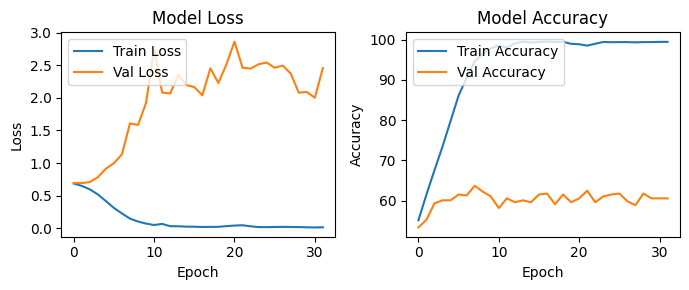

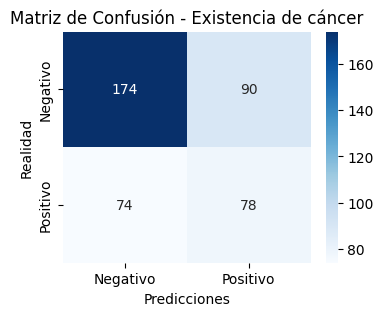

Precisión global: 60.58%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.70      0.66      0.68       264
    Positivo       0.46      0.51      0.49       152

    accuracy                           0.61       416
   macro avg       0.58      0.59      0.58       416
weighted avg       0.61      0.61      0.61       416

Precisión: 0.46
Sensibilidad (Recall): 0.51
F1-Score: 0.49
Accuracy: 0.61
Especificidad: 0.66


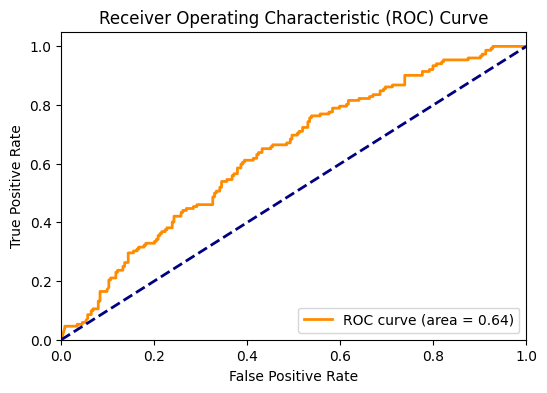

0.6362888755980861

In [ ]:
models_list.append("CNN");
train_losses_list.append(train_losses)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_losses)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_losses, val_losses, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
model = EnhancedCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = modelsdir + '/EnhancedCNN.pth'
eaStop = EarlyStopping(fichModel, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, train_accu, val_losses, val_accu = trainModel(model,train_loader,test_loader,criterion,optimizer,40,device,eaStop)

Epoch 1/40: 100%|██████████| 210/210 [00:09<00:00, 22.16it/s]


Train Loss: 0.671, Train Accuracy: 61.19%, Val Loss: 0.6520, Val Accuracy: 59.62%, Time: 9.84 seconds
Validation loss mejorada a 0.652012. Guardando modelo...


Epoch 2/40: 100%|██████████| 210/210 [00:10<00:00, 20.86it/s]


Train Loss: 0.620, Train Accuracy: 64.97%, Val Loss: 0.6997, Val Accuracy: 61.06%, Time: 10.51 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 3/40: 100%|██████████| 210/210 [00:09<00:00, 22.70it/s]


Train Loss: 0.579, Train Accuracy: 68.54%, Val Loss: 0.6463, Val Accuracy: 62.02%, Time: 9.61 seconds
Validation loss mejorada a 0.646273. Guardando modelo...


Epoch 4/40: 100%|██████████| 210/210 [00:09<00:00, 22.71it/s]


Train Loss: 0.549, Train Accuracy: 71.43%, Val Loss: 0.6984, Val Accuracy: 62.98%, Time: 9.64 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 5/40: 100%|██████████| 210/210 [00:09<00:00, 21.73it/s]


Train Loss: 0.525, Train Accuracy: 72.80%, Val Loss: 0.6899, Val Accuracy: 62.02%, Time: 10.07 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 6/40: 100%|██████████| 210/210 [00:09<00:00, 21.59it/s]


Train Loss: 0.494, Train Accuracy: 75.95%, Val Loss: 0.6913, Val Accuracy: 63.94%, Time: 10.19 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 7/40: 100%|██████████| 210/210 [00:09<00:00, 22.88it/s]


Train Loss: 0.475, Train Accuracy: 76.67%, Val Loss: 0.6837, Val Accuracy: 63.70%, Time: 9.54 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 8/40: 100%|██████████| 210/210 [00:09<00:00, 22.73it/s]


Train Loss: 0.433, Train Accuracy: 79.70%, Val Loss: 0.7391, Val Accuracy: 62.02%, Time: 9.58 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 9/40: 100%|██████████| 210/210 [00:09<00:00, 21.77it/s]


Train Loss: 0.408, Train Accuracy: 81.22%, Val Loss: 0.7393, Val Accuracy: 62.98%, Time: 10.08 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 10/40: 100%|██████████| 210/210 [00:09<00:00, 22.37it/s]


Train Loss: 0.390, Train Accuracy: 82.44%, Val Loss: 0.7724, Val Accuracy: 63.94%, Time: 9.77 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 11/40: 100%|██████████| 210/210 [00:09<00:00, 22.72it/s]


Train Loss: 0.362, Train Accuracy: 84.05%, Val Loss: 0.8169, Val Accuracy: 64.18%, Time: 9.60 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 12/40: 100%|██████████| 210/210 [00:09<00:00, 22.56it/s]


Train Loss: 0.337, Train Accuracy: 85.98%, Val Loss: 0.8346, Val Accuracy: 63.94%, Time: 9.65 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 13/40: 100%|██████████| 210/210 [00:09<00:00, 22.43it/s]


Train Loss: 0.324, Train Accuracy: 85.74%, Val Loss: 0.8029, Val Accuracy: 62.98%, Time: 9.83 seconds
EarlyStopping no mejoró en 10 épocas


Epoch 14/40: 100%|██████████| 210/210 [00:09<00:00, 22.62it/s]


Train Loss: 0.274, Train Accuracy: 88.48%, Val Loss: 0.8928, Val Accuracy: 60.82%, Time: 9.66 seconds
EarlyStopping no mejoró en 11 épocas


Epoch 15/40: 100%|██████████| 210/210 [00:09<00:00, 22.35it/s]


Train Loss: 0.280, Train Accuracy: 88.75%, Val Loss: 0.9706, Val Accuracy: 60.58%, Time: 9.76 seconds
EarlyStopping no mejoró en 12 épocas


Epoch 16/40: 100%|██████████| 210/210 [00:08<00:00, 23.54it/s]


Train Loss: 0.249, Train Accuracy: 89.73%, Val Loss: 0.9618, Val Accuracy: 61.78%, Time: 9.27 seconds
EarlyStopping no mejoró en 13 épocas


Epoch 17/40: 100%|██████████| 210/210 [00:09<00:00, 23.25it/s]


Train Loss: 0.240, Train Accuracy: 90.65%, Val Loss: 1.0047, Val Accuracy: 64.66%, Time: 9.43 seconds
EarlyStopping no mejoró en 14 épocas


Epoch 18/40: 100%|██████████| 210/210 [00:09<00:00, 23.06it/s]


Train Loss: 0.246, Train Accuracy: 89.38%, Val Loss: 0.9854, Val Accuracy: 65.14%, Time: 9.46 seconds
EarlyStopping no mejoró en 15 épocas
Early Stopping activado. Proceso detenido!


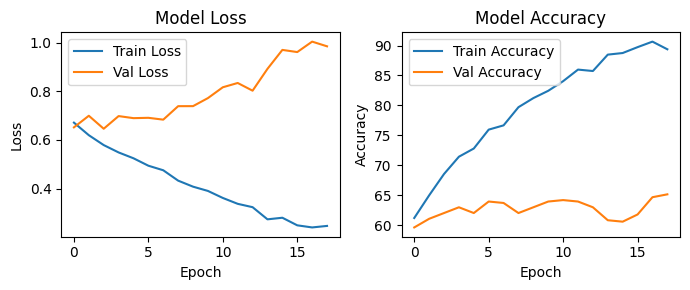

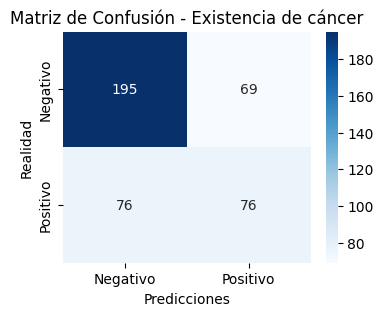

Precisión global: 65.14%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.72      0.74      0.73       264
    Positivo       0.52      0.50      0.51       152

    accuracy                           0.65       416
   macro avg       0.62      0.62      0.62       416
weighted avg       0.65      0.65      0.65       416

Precisión: 0.52
Sensibilidad (Recall): 0.50
F1-Score: 0.51
Accuracy: 0.65
Especificidad: 0.74


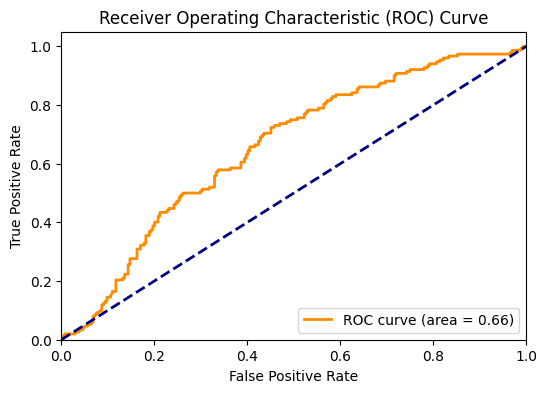

0.6556768341307815

In [ ]:
models_list.append("EnhancedCNN");
train_losses_list.append(train_losses)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_losses)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_losses, val_losses, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
# Global Contrast Normalization

def global_contrast_normalization(image_tensor):
    mean = torch.mean(image_tensor)
    std_dev = torch.std(image_tensor)
    gcn_image_tensor = (image_tensor - mean) / torch.sqrt(std_dev**2 + 10e-6)

    return gcn_image_tensor

X_train_gcn = global_contrast_normalization(X_train)
X_test_gcn = global_contrast_normalization(X_test)


train_dataset = TensorDataset(X_train_gcn, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test_gcn, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

Epoch 1/50: 100%|██████████| 210/210 [00:06<00:00, 33.27it/s]


Train Loss: 0.672, Train Accuracy: 57.65%, Val Loss: 0.6349, Val Accuracy: 62.74%, Time: 6.60 seconds
Validation loss mejorada a 0.634931. Guardando modelo...


Epoch 2/50: 100%|██████████| 210/210 [00:05<00:00, 35.00it/s]


Train Loss: 0.605, Train Accuracy: 66.64%, Val Loss: 0.7124, Val Accuracy: 58.41%, Time: 6.30 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 3/50: 100%|██████████| 210/210 [00:06<00:00, 34.97it/s]


Train Loss: 0.511, Train Accuracy: 72.74%, Val Loss: 0.7765, Val Accuracy: 54.81%, Time: 6.30 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 4/50: 100%|██████████| 210/210 [00:06<00:00, 34.52it/s]


Train Loss: 0.426, Train Accuracy: 77.44%, Val Loss: 0.9924, Val Accuracy: 60.10%, Time: 6.38 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 5/50: 100%|██████████| 210/210 [00:06<00:00, 34.42it/s]


Train Loss: 0.337, Train Accuracy: 83.72%, Val Loss: 0.8886, Val Accuracy: 62.26%, Time: 6.38 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 6/50: 100%|██████████| 210/210 [00:06<00:00, 34.71it/s]


Train Loss: 0.269, Train Accuracy: 88.27%, Val Loss: 1.1020, Val Accuracy: 60.58%, Time: 6.36 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 7/50: 100%|██████████| 210/210 [00:05<00:00, 35.30it/s]


Train Loss: 0.189, Train Accuracy: 92.14%, Val Loss: 1.3599, Val Accuracy: 64.42%, Time: 6.27 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 8/50: 100%|██████████| 210/210 [00:06<00:00, 31.79it/s]


Train Loss: 0.140, Train Accuracy: 94.73%, Val Loss: 1.6754, Val Accuracy: 59.38%, Time: 6.88 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 9/50: 100%|██████████| 210/210 [00:05<00:00, 35.86it/s]


Train Loss: 0.113, Train Accuracy: 96.19%, Val Loss: 1.9989, Val Accuracy: 62.02%, Time: 6.13 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 10/50: 100%|██████████| 210/210 [00:05<00:00, 35.50it/s]


Train Loss: 0.085, Train Accuracy: 97.05%, Val Loss: 2.3103, Val Accuracy: 63.46%, Time: 6.20 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 11/50: 100%|██████████| 210/210 [00:05<00:00, 35.85it/s]


Train Loss: 0.064, Train Accuracy: 98.01%, Val Loss: 1.9608, Val Accuracy: 57.93%, Time: 6.14 seconds
EarlyStopping no mejoró en 10 épocas


Epoch 12/50: 100%|██████████| 210/210 [00:05<00:00, 35.51it/s]


Train Loss: 0.051, Train Accuracy: 98.48%, Val Loss: 2.1331, Val Accuracy: 62.02%, Time: 6.20 seconds
EarlyStopping no mejoró en 11 épocas


Epoch 13/50: 100%|██████████| 210/210 [00:05<00:00, 35.45it/s]


Train Loss: 0.046, Train Accuracy: 98.69%, Val Loss: 2.4531, Val Accuracy: 61.78%, Time: 6.20 seconds
EarlyStopping no mejoró en 12 épocas


Epoch 14/50: 100%|██████████| 210/210 [00:05<00:00, 35.76it/s]


Train Loss: 0.057, Train Accuracy: 98.39%, Val Loss: 2.2597, Val Accuracy: 61.54%, Time: 6.16 seconds
EarlyStopping no mejoró en 13 épocas


Epoch 15/50: 100%|██████████| 210/210 [00:05<00:00, 35.13it/s]


Train Loss: 0.064, Train Accuracy: 98.01%, Val Loss: 2.2965, Val Accuracy: 62.74%, Time: 6.26 seconds
EarlyStopping no mejoró en 14 épocas


Epoch 16/50: 100%|██████████| 210/210 [00:05<00:00, 35.68it/s]


Train Loss: 0.033, Train Accuracy: 99.08%, Val Loss: 2.5382, Val Accuracy: 62.26%, Time: 6.16 seconds
EarlyStopping no mejoró en 15 épocas


Epoch 17/50: 100%|██████████| 210/210 [00:05<00:00, 35.29it/s]


Train Loss: 0.041, Train Accuracy: 99.02%, Val Loss: 2.3028, Val Accuracy: 63.94%, Time: 6.23 seconds
EarlyStopping no mejoró en 16 épocas


Epoch 18/50: 100%|██████████| 210/210 [00:05<00:00, 36.06it/s]


Train Loss: 0.035, Train Accuracy: 98.84%, Val Loss: 2.2427, Val Accuracy: 61.78%, Time: 6.10 seconds
EarlyStopping no mejoró en 17 épocas


Epoch 19/50: 100%|██████████| 210/210 [00:05<00:00, 35.30it/s]


Train Loss: 0.038, Train Accuracy: 99.08%, Val Loss: 2.4551, Val Accuracy: 59.62%, Time: 6.25 seconds
EarlyStopping no mejoró en 18 épocas


Epoch 20/50: 100%|██████████| 210/210 [00:05<00:00, 35.79it/s]


Train Loss: 0.026, Train Accuracy: 99.17%, Val Loss: 2.6171, Val Accuracy: 61.06%, Time: 6.15 seconds
EarlyStopping no mejoró en 19 épocas


Epoch 21/50: 100%|██████████| 210/210 [00:05<00:00, 35.54it/s]


Train Loss: 0.026, Train Accuracy: 99.26%, Val Loss: 2.3379, Val Accuracy: 61.06%, Time: 6.21 seconds
EarlyStopping no mejoró en 20 épocas


Epoch 22/50: 100%|██████████| 210/210 [00:06<00:00, 34.01it/s]


Train Loss: 0.036, Train Accuracy: 98.90%, Val Loss: 2.4043, Val Accuracy: 60.82%, Time: 6.45 seconds
EarlyStopping no mejoró en 21 épocas


Epoch 23/50: 100%|██████████| 210/210 [00:05<00:00, 35.71it/s]


Train Loss: 0.031, Train Accuracy: 98.87%, Val Loss: 2.3561, Val Accuracy: 62.74%, Time: 6.17 seconds
EarlyStopping no mejoró en 22 épocas


Epoch 24/50: 100%|██████████| 210/210 [00:05<00:00, 35.47it/s]


Train Loss: 0.030, Train Accuracy: 99.20%, Val Loss: 2.2517, Val Accuracy: 61.78%, Time: 6.20 seconds
EarlyStopping no mejoró en 23 épocas


Epoch 25/50: 100%|██████████| 210/210 [00:06<00:00, 34.18it/s]


Train Loss: 0.058, Train Accuracy: 98.10%, Val Loss: 2.3880, Val Accuracy: 62.02%, Time: 6.42 seconds
EarlyStopping no mejoró en 24 épocas


Epoch 26/50: 100%|██████████| 210/210 [00:05<00:00, 35.33it/s]


Train Loss: 0.058, Train Accuracy: 98.24%, Val Loss: 2.5648, Val Accuracy: 62.98%, Time: 6.22 seconds
EarlyStopping no mejoró en 25 épocas


Epoch 27/50: 100%|██████████| 210/210 [00:05<00:00, 35.97it/s]


Train Loss: 0.026, Train Accuracy: 99.26%, Val Loss: 2.2294, Val Accuracy: 62.02%, Time: 6.11 seconds
EarlyStopping no mejoró en 26 épocas


Epoch 28/50: 100%|██████████| 210/210 [00:05<00:00, 35.45it/s]


Train Loss: 0.021, Train Accuracy: 99.32%, Val Loss: 2.3216, Val Accuracy: 63.46%, Time: 6.20 seconds
EarlyStopping no mejoró en 27 épocas


Epoch 29/50: 100%|██████████| 210/210 [00:05<00:00, 35.91it/s]


Train Loss: 0.016, Train Accuracy: 99.29%, Val Loss: 2.4162, Val Accuracy: 62.98%, Time: 6.12 seconds
EarlyStopping no mejoró en 28 épocas


Epoch 30/50: 100%|██████████| 210/210 [00:05<00:00, 35.68it/s]


Train Loss: 0.018, Train Accuracy: 99.29%, Val Loss: 2.4419, Val Accuracy: 63.94%, Time: 6.18 seconds
EarlyStopping no mejoró en 29 épocas


Epoch 31/50: 100%|██████████| 210/210 [00:05<00:00, 35.81it/s]


Train Loss: 0.017, Train Accuracy: 99.46%, Val Loss: 2.2425, Val Accuracy: 62.50%, Time: 6.14 seconds
EarlyStopping no mejoró en 30 épocas
Early Stopping activado. Proceso detenido!


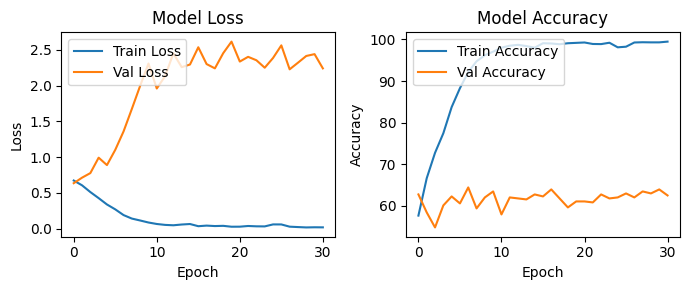

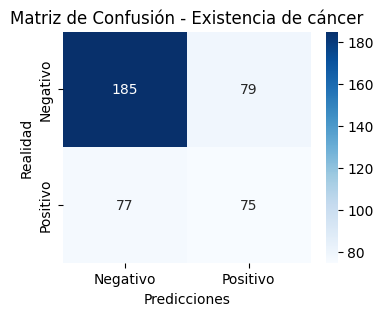

Precisión global: 62.50%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.71      0.70      0.70       264
    Positivo       0.49      0.49      0.49       152

    accuracy                           0.62       416
   macro avg       0.60      0.60      0.60       416
weighted avg       0.63      0.62      0.63       416

Precisión: 0.49
Sensibilidad (Recall): 0.49
F1-Score: 0.49
Accuracy: 0.62
Especificidad: 0.70


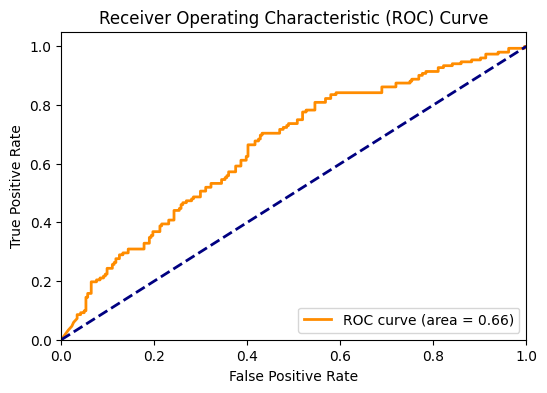

0.6560007974481659

In [ ]:
model = CNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = modelsdir + '/CNN_GCN.pth'
eaStop = EarlyStopping(fichModel, patience=30, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, train_accu, val_losses, val_accu = trainModel(model,train_loader,test_loader,criterion,optimizer,50,device,eaStop)

models_list.append("CNN_GCN");
train_losses_list.append(train_losses)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_losses)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_losses, val_losses, train_accu, val_accu)

metrics(model, test_loader)

Epoch 1/40: 100%|██████████| 210/210 [00:08<00:00, 23.73it/s]


Train Loss: 0.685, Train Accuracy: 58.78%, Val Loss: 0.6574, Val Accuracy: 60.10%, Time: 9.19 seconds
Validation loss mejorada a 0.657441. Guardando modelo...


Epoch 2/40: 100%|██████████| 210/210 [00:08<00:00, 23.91it/s]


Train Loss: 0.630, Train Accuracy: 64.67%, Val Loss: 0.6523, Val Accuracy: 61.30%, Time: 9.14 seconds
Validation loss mejorada a 0.652259. Guardando modelo...


Epoch 3/40: 100%|██████████| 210/210 [00:08<00:00, 23.71it/s]


Train Loss: 0.599, Train Accuracy: 68.39%, Val Loss: 0.6631, Val Accuracy: 61.06%, Time: 9.21 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 4/40: 100%|██████████| 210/210 [00:08<00:00, 23.75it/s]


Train Loss: 0.572, Train Accuracy: 70.57%, Val Loss: 0.6691, Val Accuracy: 60.82%, Time: 9.18 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 5/40: 100%|██████████| 210/210 [00:08<00:00, 23.64it/s]


Train Loss: 0.539, Train Accuracy: 73.01%, Val Loss: 0.6819, Val Accuracy: 60.58%, Time: 9.23 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 6/40: 100%|██████████| 210/210 [00:08<00:00, 23.80it/s]


Train Loss: 0.512, Train Accuracy: 74.11%, Val Loss: 0.6756, Val Accuracy: 64.90%, Time: 9.17 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 7/40: 100%|██████████| 210/210 [00:08<00:00, 23.74it/s]


Train Loss: 0.485, Train Accuracy: 76.58%, Val Loss: 0.7167, Val Accuracy: 63.70%, Time: 9.19 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 8/40: 100%|██████████| 210/210 [00:08<00:00, 24.03it/s]


Train Loss: 0.449, Train Accuracy: 78.60%, Val Loss: 0.7171, Val Accuracy: 64.42%, Time: 9.09 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 9/40: 100%|██████████| 210/210 [00:08<00:00, 23.72it/s]


Train Loss: 0.430, Train Accuracy: 79.46%, Val Loss: 0.7122, Val Accuracy: 63.22%, Time: 9.20 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 10/40: 100%|██████████| 210/210 [00:08<00:00, 23.76it/s]


Train Loss: 0.381, Train Accuracy: 82.50%, Val Loss: 0.7946, Val Accuracy: 63.94%, Time: 9.18 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 11/40: 100%|██████████| 210/210 [00:08<00:00, 23.95it/s]


Train Loss: 0.367, Train Accuracy: 83.45%, Val Loss: 0.8204, Val Accuracy: 62.50%, Time: 9.12 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 12/40: 100%|██████████| 210/210 [00:08<00:00, 23.84it/s]


Train Loss: 0.348, Train Accuracy: 84.46%, Val Loss: 0.7808, Val Accuracy: 63.22%, Time: 9.15 seconds
EarlyStopping no mejoró en 10 épocas


Epoch 13/40: 100%|██████████| 210/210 [00:08<00:00, 23.78it/s]


Train Loss: 0.313, Train Accuracy: 86.79%, Val Loss: 0.8240, Val Accuracy: 64.18%, Time: 9.17 seconds
EarlyStopping no mejoró en 11 épocas


Epoch 14/40: 100%|██████████| 210/210 [00:08<00:00, 23.92it/s]


Train Loss: 0.306, Train Accuracy: 87.23%, Val Loss: 0.8740, Val Accuracy: 62.98%, Time: 9.13 seconds
EarlyStopping no mejoró en 12 épocas


Epoch 15/40: 100%|██████████| 210/210 [00:08<00:00, 23.75it/s]


Train Loss: 0.298, Train Accuracy: 87.20%, Val Loss: 0.8752, Val Accuracy: 63.94%, Time: 9.18 seconds
EarlyStopping no mejoró en 13 épocas


Epoch 16/40: 100%|██████████| 210/210 [00:08<00:00, 23.72it/s]


Train Loss: 0.260, Train Accuracy: 88.96%, Val Loss: 0.9371, Val Accuracy: 62.74%, Time: 9.20 seconds
EarlyStopping no mejoró en 14 épocas


Epoch 17/40: 100%|██████████| 210/210 [00:08<00:00, 23.94it/s]


Train Loss: 0.246, Train Accuracy: 89.52%, Val Loss: 0.9639, Val Accuracy: 64.66%, Time: 9.12 seconds
EarlyStopping no mejoró en 15 épocas
Early Stopping activado. Proceso detenido!


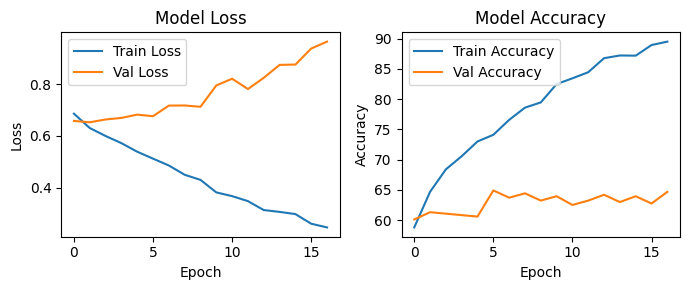

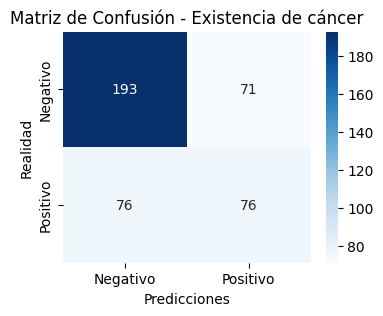

Precisión global: 64.66%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.72      0.73      0.72       264
    Positivo       0.52      0.50      0.51       152

    accuracy                           0.65       416
   macro avg       0.62      0.62      0.62       416
weighted avg       0.64      0.65      0.65       416

Precisión: 0.52
Sensibilidad (Recall): 0.50
F1-Score: 0.51
Accuracy: 0.65
Especificidad: 0.73


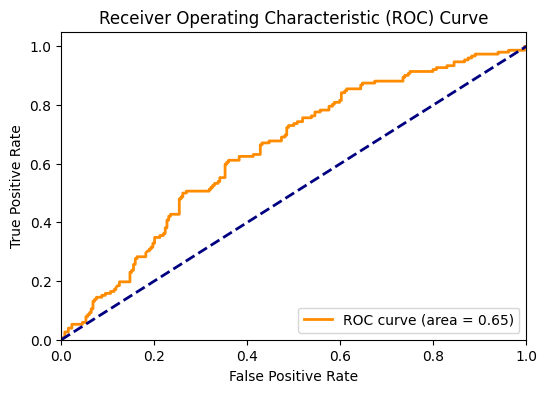

0.6463815789473684

In [ ]:
model = EnhancedCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = modelsdir + '/EnhancedCNN_GCN.pth'
eaStop = EarlyStopping(fichModel, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, train_accu, val_losses, val_accu = trainModel(model,train_loader,test_loader,criterion,optimizer,40,device,eaStop)

models_list.append("EnhancedCNN_GCN");
train_losses_list.append(train_losses)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_losses)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_losses, val_losses, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
from skimage import exposure

def local_contrast_normalization(tensor):
    image = tensor.numpy()

    lcn_images = []
    for i in range(image.shape[0]):
        lcn_image = exposure.equalize_adapthist(image[i], clip_limit=0.03)
        lcn_images.append(lcn_image)

    lcn_tensor = torch.tensor(np.stack(lcn_images))

    return lcn_tensor

def global_contrast_normalization(image_tensor):
    mean = torch.mean(image_tensor)
    std_dev = torch.std(image_tensor)

    gcn_image_tensor = (image_tensor - mean) / torch.sqrt(std_dev**2 + 10e-6)

    return gcn_image_tensor

def LCN_GCN_preprocess(tensor):
    lcn_tensor = local_contrast_normalization(tensor)
    gcn_tensor = global_contrast_normalization(lcn_tensor)

    return gcn_tensor

X_train_LCN_GCN = LCN_GCN_preprocess(X_train)
X_test_LCN_GCN = LCN_GCN_preprocess(X_test)

# Dataset y DataLoader CON LOCAL CONTRAST NORMALIZATION Y GLOBAL CONTRAST NORMALIZATION
train_dataset = TensorDataset(X_train_LCN_GCN, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test_LCN_GCN, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

Epoch 1/50: 100%|██████████| 210/210 [00:06<00:00, 32.12it/s]


Train Loss: 0.673, Train Accuracy: 59.29%, Val Loss: 0.6988, Val Accuracy: 54.09%, Time: 6.83 seconds
Validation loss mejorada a 0.698830. Guardando modelo...


Epoch 2/50: 100%|██████████| 210/210 [00:08<00:00, 26.14it/s]


Train Loss: 0.612, Train Accuracy: 66.70%, Val Loss: 0.6889, Val Accuracy: 56.25%, Time: 8.39 seconds
Validation loss mejorada a 0.688896. Guardando modelo...


Epoch 3/50: 100%|██████████| 210/210 [00:07<00:00, 29.69it/s]


Train Loss: 0.530, Train Accuracy: 71.88%, Val Loss: 0.9062, Val Accuracy: 52.16%, Time: 7.37 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 4/50: 100%|██████████| 210/210 [00:05<00:00, 35.62it/s]


Train Loss: 0.410, Train Accuracy: 81.10%, Val Loss: 1.0270, Val Accuracy: 56.49%, Time: 6.17 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 5/50: 100%|██████████| 210/210 [00:05<00:00, 36.27it/s]


Train Loss: 0.284, Train Accuracy: 87.47%, Val Loss: 1.2133, Val Accuracy: 57.21%, Time: 6.07 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 6/50: 100%|██████████| 210/210 [00:05<00:00, 35.85it/s]


Train Loss: 0.169, Train Accuracy: 93.27%, Val Loss: 1.9248, Val Accuracy: 57.21%, Time: 6.15 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 7/50: 100%|██████████| 210/210 [00:05<00:00, 36.04it/s]


Train Loss: 0.104, Train Accuracy: 96.67%, Val Loss: 2.6969, Val Accuracy: 55.05%, Time: 6.11 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 8/50: 100%|██████████| 210/210 [00:05<00:00, 36.03it/s]


Train Loss: 0.062, Train Accuracy: 98.21%, Val Loss: 2.9654, Val Accuracy: 57.45%, Time: 6.12 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 9/50: 100%|██████████| 210/210 [00:05<00:00, 35.32it/s]


Train Loss: 0.036, Train Accuracy: 99.26%, Val Loss: 2.6426, Val Accuracy: 54.33%, Time: 6.23 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 10/50: 100%|██████████| 210/210 [00:05<00:00, 36.11it/s]


Train Loss: 0.047, Train Accuracy: 98.72%, Val Loss: 3.0334, Val Accuracy: 53.12%, Time: 6.09 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 11/50: 100%|██████████| 210/210 [00:06<00:00, 34.98it/s]


Train Loss: 0.048, Train Accuracy: 98.54%, Val Loss: 2.7941, Val Accuracy: 55.53%, Time: 6.29 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 12/50: 100%|██████████| 210/210 [00:05<00:00, 35.85it/s]


Train Loss: 0.030, Train Accuracy: 99.38%, Val Loss: 2.9015, Val Accuracy: 59.13%, Time: 6.14 seconds
EarlyStopping no mejoró en 10 épocas


Epoch 13/50: 100%|██████████| 210/210 [00:05<00:00, 35.71it/s]


Train Loss: 0.029, Train Accuracy: 99.26%, Val Loss: 2.9392, Val Accuracy: 57.93%, Time: 6.18 seconds
EarlyStopping no mejoró en 11 épocas


Epoch 14/50: 100%|██████████| 210/210 [00:05<00:00, 35.78it/s]


Train Loss: 0.022, Train Accuracy: 99.52%, Val Loss: 2.7920, Val Accuracy: 56.25%, Time: 6.15 seconds
EarlyStopping no mejoró en 12 épocas


Epoch 15/50: 100%|██████████| 210/210 [00:05<00:00, 35.91it/s]


Train Loss: 0.013, Train Accuracy: 99.43%, Val Loss: 2.8153, Val Accuracy: 56.25%, Time: 6.13 seconds
EarlyStopping no mejoró en 13 épocas


Epoch 16/50: 100%|██████████| 210/210 [00:05<00:00, 35.63it/s]


Train Loss: 0.013, Train Accuracy: 99.46%, Val Loss: 3.2167, Val Accuracy: 57.69%, Time: 6.18 seconds
EarlyStopping no mejoró en 14 épocas


Epoch 17/50: 100%|██████████| 210/210 [00:05<00:00, 36.03it/s]


Train Loss: 0.017, Train Accuracy: 99.52%, Val Loss: 2.8763, Val Accuracy: 56.01%, Time: 6.11 seconds
EarlyStopping no mejoró en 15 épocas
Early Stopping activado. Proceso detenido!


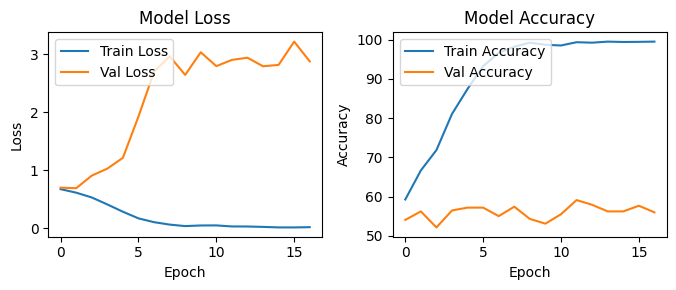

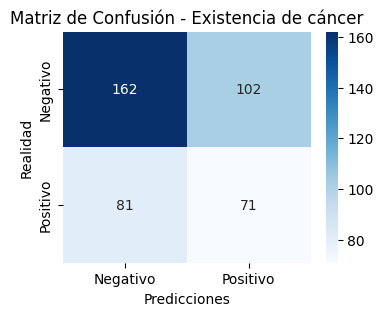

Precisión global: 56.01%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.67      0.61      0.64       264
    Positivo       0.41      0.47      0.44       152

    accuracy                           0.56       416
   macro avg       0.54      0.54      0.54       416
weighted avg       0.57      0.56      0.57       416

Precisión: 0.41
Sensibilidad (Recall): 0.47
F1-Score: 0.44
Accuracy: 0.56
Especificidad: 0.61


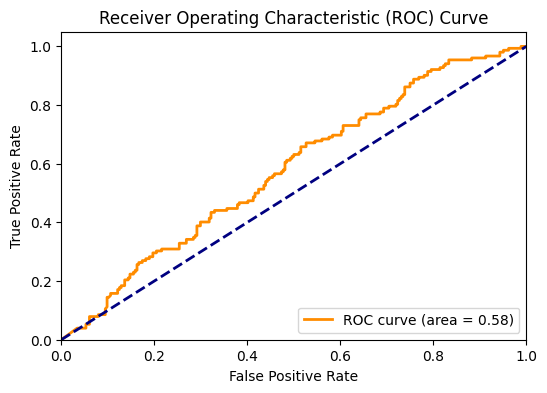

0.5791716507177034

In [ ]:
model = CNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = modelsdir + '/CNN_LCN_GCN.pth'
eaStop = EarlyStopping(fichModel, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, train_accu, val_losses, val_accu = trainModel(model,train_loader,test_loader,criterion,optimizer,50,device,eaStop)

models_list.append("CNN_LCN_GCN");
train_losses_list.append(train_losses)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_losses)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_losses, val_losses, train_accu, val_accu)

metrics(model, test_loader)

Epoch 1/40: 100%|██████████| 210/210 [00:08<00:00, 23.78it/s]


Train Loss: 0.685, Train Accuracy: 58.24%, Val Loss: 0.6882, Val Accuracy: 56.25%, Time: 9.17 seconds
Validation loss mejorada a 0.688215. Guardando modelo...


Epoch 2/40: 100%|██████████| 210/210 [00:08<00:00, 23.72it/s]


Train Loss: 0.636, Train Accuracy: 64.29%, Val Loss: 0.6600, Val Accuracy: 60.34%, Time: 9.21 seconds
Validation loss mejorada a 0.659980. Guardando modelo...


Epoch 3/40: 100%|██████████| 210/210 [00:08<00:00, 23.63it/s]


Train Loss: 0.607, Train Accuracy: 66.04%, Val Loss: 0.6668, Val Accuracy: 60.34%, Time: 9.23 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 4/40: 100%|██████████| 210/210 [00:08<00:00, 23.75it/s]


Train Loss: 0.581, Train Accuracy: 69.05%, Val Loss: 0.7158, Val Accuracy: 55.29%, Time: 9.21 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 5/40: 100%|██████████| 210/210 [00:08<00:00, 23.72it/s]


Train Loss: 0.544, Train Accuracy: 73.15%, Val Loss: 0.7178, Val Accuracy: 56.97%, Time: 9.20 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 6/40: 100%|██████████| 210/210 [00:08<00:00, 23.66it/s]


Train Loss: 0.520, Train Accuracy: 74.14%, Val Loss: 0.7936, Val Accuracy: 54.33%, Time: 9.22 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 7/40: 100%|██████████| 210/210 [00:08<00:00, 23.83it/s]


Train Loss: 0.488, Train Accuracy: 75.86%, Val Loss: 0.8345, Val Accuracy: 54.33%, Time: 9.16 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 8/40: 100%|██████████| 210/210 [00:08<00:00, 23.52it/s]


Train Loss: 0.428, Train Accuracy: 80.24%, Val Loss: 0.8042, Val Accuracy: 56.01%, Time: 9.28 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 9/40: 100%|██████████| 210/210 [00:08<00:00, 23.65it/s]


Train Loss: 0.392, Train Accuracy: 82.68%, Val Loss: 0.8404, Val Accuracy: 58.65%, Time: 9.23 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 10/40: 100%|██████████| 210/210 [00:08<00:00, 23.82it/s]


Train Loss: 0.351, Train Accuracy: 84.61%, Val Loss: 0.9271, Val Accuracy: 57.45%, Time: 9.17 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 11/40: 100%|██████████| 210/210 [00:08<00:00, 23.58it/s]


Train Loss: 0.301, Train Accuracy: 87.59%, Val Loss: 0.9245, Val Accuracy: 59.86%, Time: 9.25 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 12/40: 100%|██████████| 210/210 [00:08<00:00, 23.52it/s]


Train Loss: 0.273, Train Accuracy: 88.99%, Val Loss: 0.9941, Val Accuracy: 59.13%, Time: 9.28 seconds
EarlyStopping no mejoró en 10 épocas


Epoch 13/40: 100%|██████████| 210/210 [00:08<00:00, 23.79it/s]


Train Loss: 0.226, Train Accuracy: 91.07%, Val Loss: 1.0430, Val Accuracy: 59.86%, Time: 9.18 seconds
EarlyStopping no mejoró en 11 épocas


Epoch 14/40: 100%|██████████| 210/210 [00:08<00:00, 23.53it/s]


Train Loss: 0.231, Train Accuracy: 90.86%, Val Loss: 1.0674, Val Accuracy: 59.38%, Time: 9.27 seconds
EarlyStopping no mejoró en 12 épocas


Epoch 15/40: 100%|██████████| 210/210 [00:08<00:00, 23.47it/s]


Train Loss: 0.186, Train Accuracy: 92.89%, Val Loss: 1.1678, Val Accuracy: 60.58%, Time: 9.32 seconds
EarlyStopping no mejoró en 13 épocas


Epoch 16/40: 100%|██████████| 210/210 [00:08<00:00, 23.59it/s]


Train Loss: 0.189, Train Accuracy: 92.80%, Val Loss: 1.2685, Val Accuracy: 56.73%, Time: 9.25 seconds
EarlyStopping no mejoró en 14 épocas


Epoch 17/40: 100%|██████████| 210/210 [00:08<00:00, 23.63it/s]


Train Loss: 0.167, Train Accuracy: 93.54%, Val Loss: 1.3448, Val Accuracy: 55.29%, Time: 9.24 seconds
EarlyStopping no mejoró en 15 épocas
Early Stopping activado. Proceso detenido!


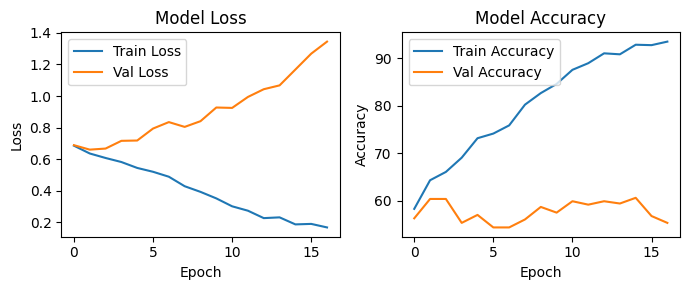

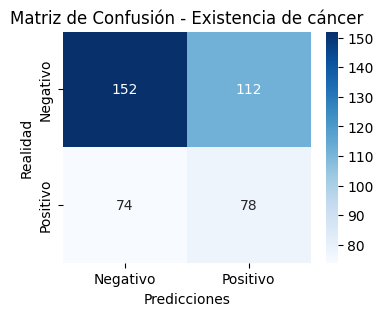

Precisión global: 55.29%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.67      0.58      0.62       264
    Positivo       0.41      0.51      0.46       152

    accuracy                           0.55       416
   macro avg       0.54      0.54      0.54       416
weighted avg       0.58      0.55      0.56       416

Precisión: 0.41
Sensibilidad (Recall): 0.51
F1-Score: 0.46
Accuracy: 0.55
Especificidad: 0.58


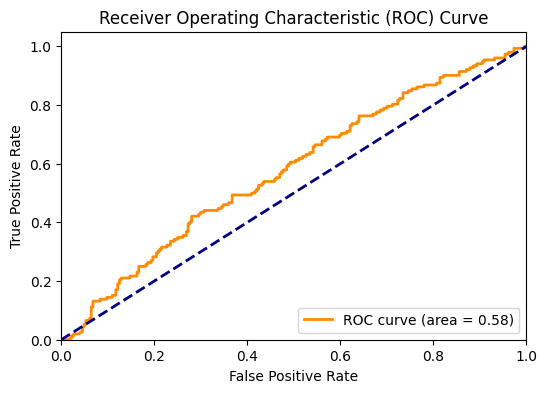

0.5761812200956937

In [ ]:
model = EnhancedCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = modelsdir + '/EnhancedCNN_LCN_GCN.pth'
eaStop = EarlyStopping(fichModel, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, train_accu, val_losses, val_accu = trainModel(model,train_loader,test_loader,criterion,optimizer,40,device,eaStop)

models_list.append("EnhancedCNN_LCN_GCN");
train_losses_list.append(train_losses)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_losses)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_losses, val_losses, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
# Prueba de almacenamiento y carga de modelos
modeloCargarFichero = datasetdir + '/modeloCNN1.pth'
modelCargado = torch.load(modeloCargarFichero, map_location=torch.device('cpu'))
print(modelCargado)

In [ ]:
## Prueba de predicción con modelo mejorado
def predict_image(model, image_path, device):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    image = image / 255.0
    image_tensor = torch.tensor(image, dtype=torch.float).unsqueeze(0)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)

    model_path = datasetdir + '/modeloCNN2.pth'
    model = torch.load(model_path, map_location=device)
    model.eval()

    with torch.no_grad():
        output = model(image_tensor)

    _, predicted_class = torch.max(output, 1)
    return predicted_class.item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_path = '/content/drive/MyDrive/cbis-ddsm/jpeg/1.3.6.1.4.1.9590.100.1.2.245063149211255120613007755642780114172/1-271.jpg'
predicted_class = predict_image(EnhancedCNN(), image_path, device)

if predicted_class == 0:
    print("Predicción: BENIGNO")
else:
    print("Predicción: MALIGNO")


Predicción: BENIGN


In [ ]:
model_path = datasetdir + '/modeloCNN2.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_path, map_location=device)

model.eval()

all_preds = []
all_labels = []

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)

    _, predicted = torch.max(outputs, 1)

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Cáncer', 'Con Cáncer'], yticklabels=['Sin Cáncer', 'Con Cáncer'])
plt.xlabel('Predicciones')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['Sin Cáncer', 'Con Cáncer'])

print(f"Precisión global: {accuracy * 100:.2f}%")
print("Informe y métricas de clasificación:")
print(report)
